In [1]:
# import library
import time
import math
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader import data as pdr
from pandas_datareader.data import DataReader
import yfinance as yf


yf.pdr_override()


import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

## Data

In [2]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

# Set up End and Start times(5 years) for data grab
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2018-11-23,43.735001,44.150002,43.025002,43.072498,41.341450,94496000,APPLE
2018-11-26,43.560001,43.737499,42.564999,43.654999,41.900547,179994000,APPLE
2018-11-27,42.877499,43.692501,42.720001,43.560001,41.809364,165549600,APPLE
2018-11-28,44.182499,45.322498,43.732498,45.235001,43.417038,184250000,APPLE
2018-11-29,45.665001,45.700001,44.424999,44.887501,43.083500,167080000,APPLE
...,...,...,...,...,...,...,...
2023-11-16,189.570007,190.960007,188.649994,189.710007,189.710007,54412900,APPLE
2023-11-17,190.250000,190.380005,188.570007,189.690002,189.690002,50922700,APPLE
2023-11-20,189.889999,191.910004,189.880005,191.449997,191.449997,46505100,APPLE


In [71]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-11-23 to 2023-11-22
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Open                           1258 non-null   float64
 1   High                           1258 non-null   float64
 2   Low                            1258 non-null   float64
 3   Close                          1258 non-null   float64
 4   Adj Close                      1258 non-null   float64
 5   Volume                         1258 non-null   int64  
 6   company_name                   1258 non-null   object 
 7   Daily Log Return               1257 non-null   float64
 8   Cumulative Sum of Log Returns  1257 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 98.3+ KB


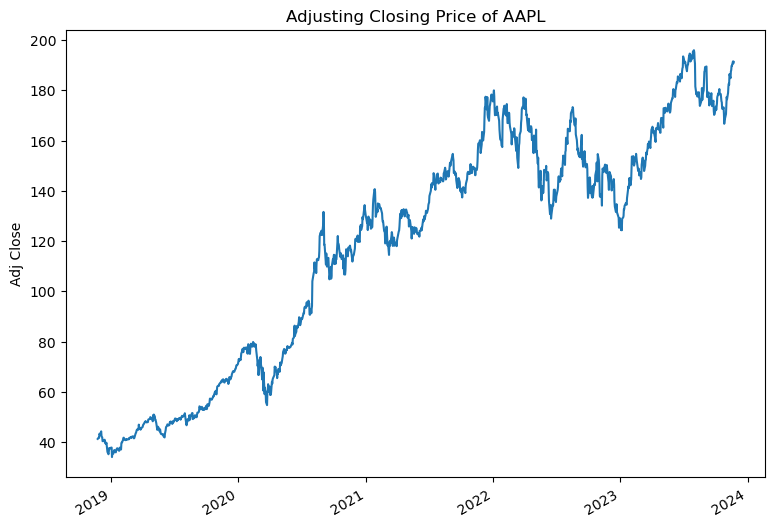

In [4]:
# Let's see a historical view of the closing price

plt.figure(figsize=(15, 10))
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Adjusting Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()
plt.savefig('adj_close_aapl.png')

In [5]:
for company in company_list:
    company['Daily Log Return'] = np.log(company['Adj Close']) - np.log(company['Adj Close'].shift(1))
    company['Cumulative Sum of Log Returns'] = company['Daily Log Return'].cumsum()

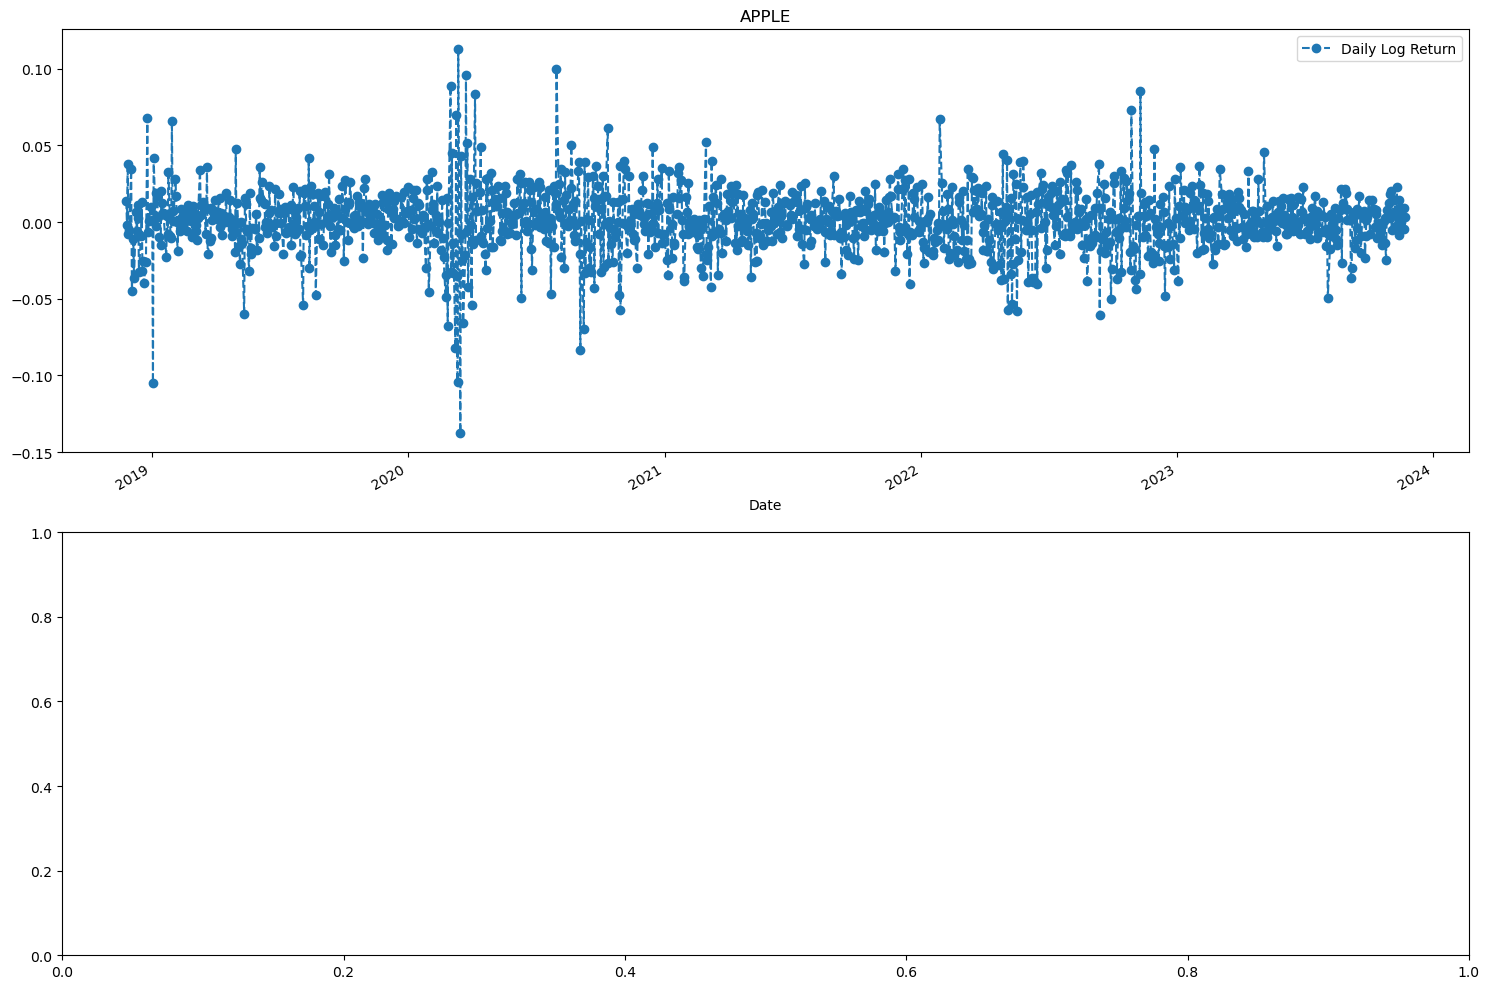

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Log Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o')

axes[0].set_title('APPLE')

fig.tight_layout()
plt.savefig('logreturn point.png')

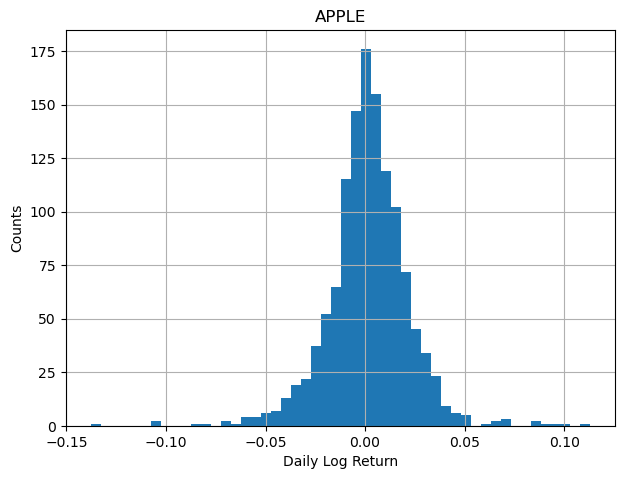

In [7]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Log Return'].hist(bins=50)
    plt.xlabel('Daily Log Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')
    
plt.tight_layout()
plt.savefig('logreturn_hist.png')

In [8]:
def input_data(series,T=10,D=1,test_ratio = 0.3):
    
    # Split into training, validation, and test sets
    test_length = int(len(series) * test_ratio)

    X = []
    Y = []
    for t in range(len(series)-T):
        x = series[t:t+T]
        X.append(x)
        y = series[t+T]
        Y.append(y)
    
    X = np.array(X).reshape(-1,T,1)
    Y = np.array(Y).reshape(-1,1)
    N = len(X)
    
    test_length = int(N * test_ratio)
    train_length = N  - test_length
    
    X_train = torch.from_numpy(X[:-test_length].astype(np.float32))
    y_train = torch.from_numpy(Y[:-test_length].astype(np.float32))
    X_test = torch.from_numpy(X[-test_length:].astype(np.float32))
    y_test = torch.from_numpy(Y[-test_length:].astype(np.float32))
    
    print("X.shape", X.shape, "Y.shape", Y.shape)
    print("the length of the train set :", X_train.shape, len(X[:-test_length]))
    print("the length of the test set :", X_test.shape, len(X[-test_length:]))
    return X_train, y_train, X_test, y_test  

In [9]:
# Training

def full_gd(model,criterion,optimizer,X_train,y_train,X_test,y_test,epochs=100):
    
    start_time = time.time()
    
    # Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for it in range(epochs):
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward and optimize
        loss.backward(retain_graph=True)
        optimizer.step()
        
        # Save losses
        train_losses[it] = loss.item()
        
        # Validation loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()
        
        if (it+1) % 5 == 0:
            print(f"Epoch {it+1}/{epochs}, Train Loss:{loss.item():.4f}, Test Loss:{test_loss.item():.4f}")
            
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')        
    return train_losses, test_losses

In [10]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [11]:
class SimpleRNN(nn.Module):
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(SimpleRNN, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.RNN(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        nonlinearity = 'relu',
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states - L x N x M
        # L: the number of RNNlayers
        # N: the number of samples or the batchsize
        # M: the number of hidden features
        h0 = torch.zeros(self.L, X.size(0), self.M)
        
        # get RNN unit output
        # out is of size (N,T,M)
        out, _ = self.rnn(X, h0)
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:,-1,:])
        return out

## Window Size Fixing

#### T = 10

In [12]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 10, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1247, 10, 1) Y.shape (1247, 1)
the length of the train set : torch.Size([873, 10, 1]) 873
the length of the test set : torch.Size([374, 10, 1]) 374
Epoch 5/100, Train Loss:0.0008, Test Loss:0.0003
Epoch 10/100, Train Loss:0.0007, Test Loss:0.0003
Epoch 15/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [13]:
# one-step forecast using true targets
test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,10,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 10-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 10-------------------------------------------
Test data RMSE:  0.017800837971630658
Test data MSE:  0.00031686983249224783
Test data MAE:  0.013231452187106299


#### T=20

In [14]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 20, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1237, 20, 1) Y.shape (1237, 1)
the length of the train set : torch.Size([866, 20, 1]) 866
the length of the test set : torch.Size([371, 20, 1]) 371
Epoch 5/100, Train Loss:0.0007, Test Loss:0.0003
Epoch 10/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 15/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [15]:
# one-step forecast using true targets
test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,20,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 20-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 20-------------------------------------------
Test data RMSE:  0.01788901459393602
Test data MSE:  0.0003200168431420559
Test data MAE:  0.013315549872397801


#### T = 40

In [16]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 40, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1217, 40, 1) Y.shape (1217, 1)
the length of the train set : torch.Size([852, 40, 1]) 852
the length of the test set : torch.Size([365, 40, 1]) 365
Epoch 5/100, Train Loss:0.0027, Test Loss:0.0006
Epoch 10/100, Train Loss:0.0034, Test Loss:0.0039
Epoch 15/100, Train Loss:0.0021, Test Loss:0.0013
Epoch 20/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0010, Test Loss:0.0009
Epoch 30/100, Train Loss:0.0008, Test Loss:0.0005
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0006, Test Loss:0.0005
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0004, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0004, Test Loss:0

In [17]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,40,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 40-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 40-------------------------------------------
Test data RMSE:  0.01752780246655791
Test data MSE:  0.00030722385930667353
Test data MAE:  0.013065616212636137


#### T = 60

In [18]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 60, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

X.shape (1197, 60, 1) Y.shape (1197, 1)
the length of the train set : torch.Size([838, 60, 1]) 838
the length of the test set : torch.Size([359, 60, 1]) 359
Epoch 5/100, Train Loss:0.0011, Test Loss:0.0042
Epoch 10/100, Train Loss:0.0030, Test Loss:0.0014
Epoch 15/100, Train Loss:0.0008, Test Loss:0.0010
Epoch 20/100, Train Loss:0.0016, Test Loss:0.0014
Epoch 25/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0007, Test Loss:0.0005
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0

In [19]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------T = 60-------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------T = 60-------------------------------------------
Test data RMSE:  0.017185026091540302
Test data MSE:  0.0002953251217669209
Test data MAE:  0.012757753090700945


window size = 60

## Simple RNN

In [20]:
series = AAPL['Daily Log Return'].values[1:].reshape(-1,1)
X_train, y_train, X_test, y_test = input_data(series, 60, 1)
# instantiate the model
rnn_model = SimpleRNN(n_inputs=1, n_hidden=20, n_rnnlayers=1,n_outputs=1)
count_parameters(rnn_model)

X.shape (1197, 60, 1) Y.shape (1197, 1)
the length of the train set : torch.Size([838, 60, 1]) 838
the length of the test set : torch.Size([359, 60, 1]) 359
    20
   400
    20
    20
    20
     1
______
   481


In [21]:
# Loss and optimizer
rnn_criterion = nn.MSELoss()
rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 0.01)
rnn_train_losses, rnn_test_losses = full_gd(rnn_model,
                                            rnn_criterion,
                                            rnn_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0005, Test Loss:0.0005
Epoch 10/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 15/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 20/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


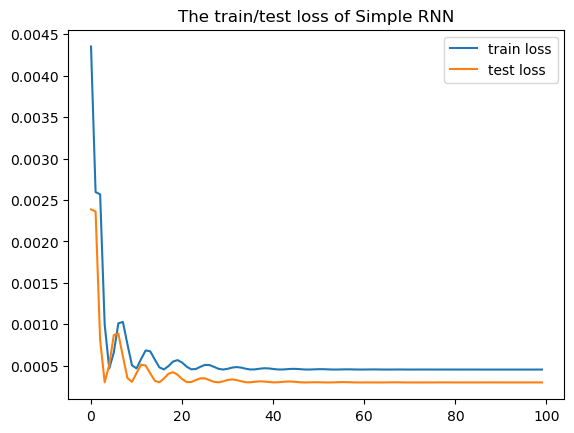

In [22]:
# Plot the train loss and calidation loss per iteration
plt.plot(rnn_train_losses, label="train loss")
plt.plot(rnn_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Simple RNN")
plt.savefig('simplernn_loss.png')

In [23]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = rnn_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("--------------------------------------Simple RNN -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

--------------------------------------Simple RNN -------------------------------------------
Test data RMSE:  0.017286170714275736
Test data MSE:  0.0002988116979630841
Test data MAE:  0.012898953795219183


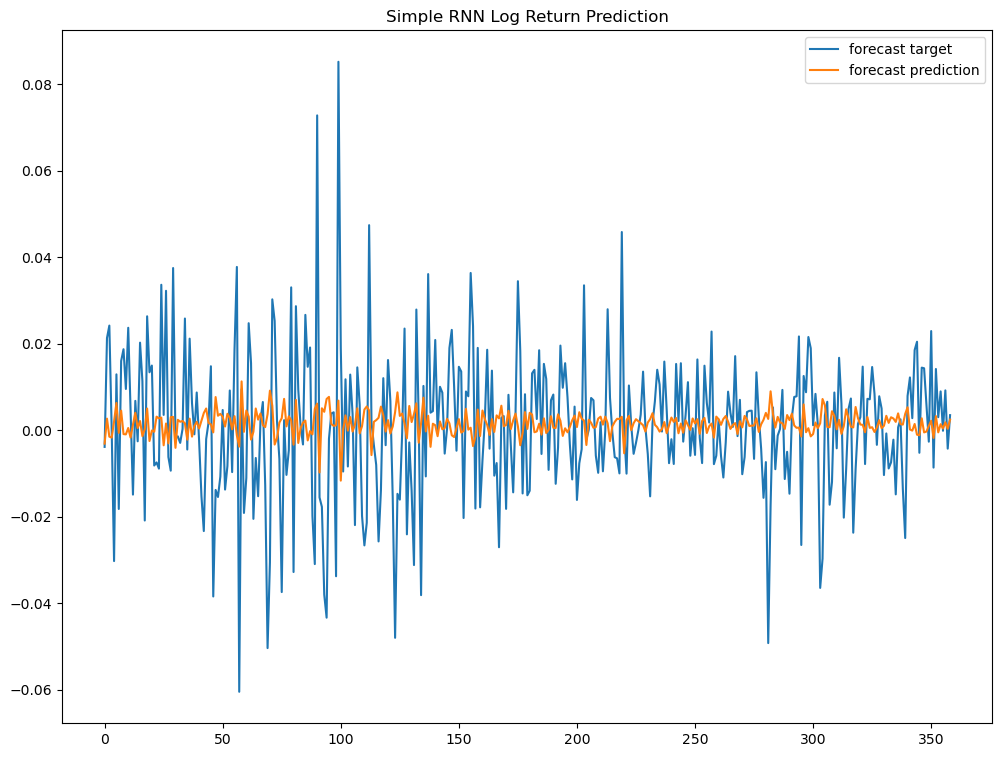

In [24]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Simple RNN Log Return Prediction")
plt.savefig('Simple RNN Log Return Prediction.png')

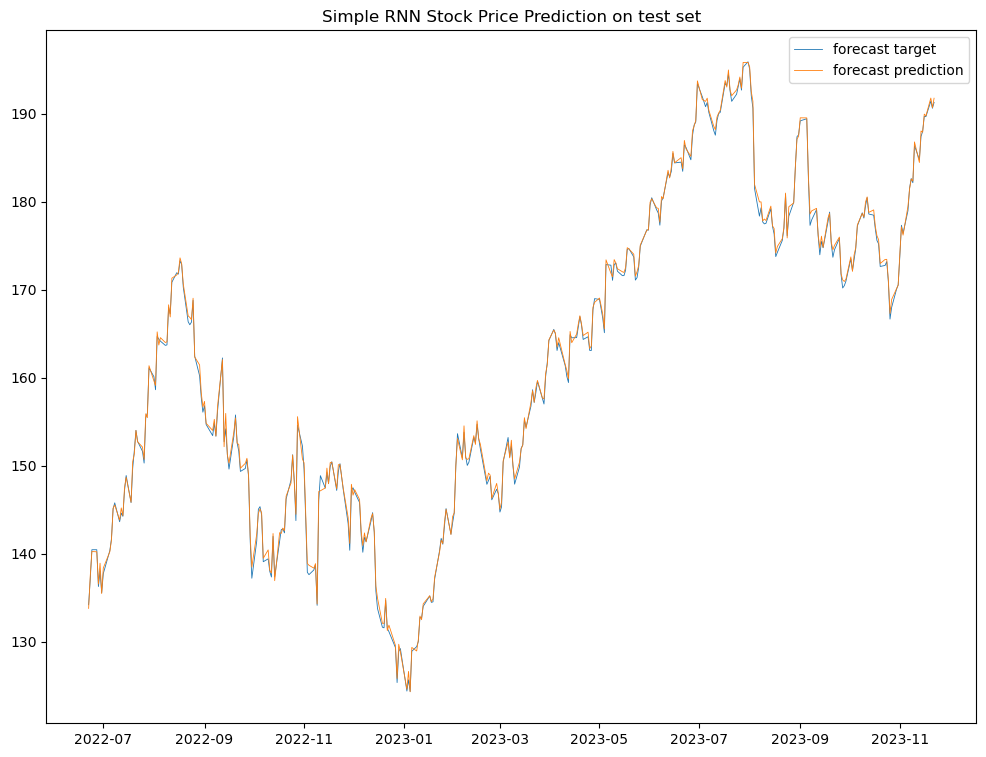

In [25]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-359:] 
plt.plot(AAPL['Adj Close'][-359:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Simple RNN Stock Price Prediction on test set")
plt.savefig('Simple RNN Stock Price Prediction.png')

In [26]:
print("--------------------------------------Simple RNN -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(AAPL['Adj Close'][-359:],back_pre)))
print("Test data MSE: ", mean_squared_error(AAPL['Adj Close'][-359:],back_pre))
print("Test data MAE: ", mean_absolute_error(AAPL['Adj Close'][-359:],back_pre))

--------------------------------------Simple RNN -------------------------------------------
Test data RMSE:  0.47400133536469835
Test data MSE:  0.22467726592751724
Test data MAE:  0.3736419022659174


## LSTM

In [27]:
class LSTMnetwork(nn.Module):
    
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(LSTMnetwork, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states 
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        

        out, _ = self.rnn(X, (h0,c0))
        
        # we only want h(T) at the final time step
        # N x M --> N x K
        out = self.fc(out[:,-1,:])
        return out

**One Layer**

In [28]:
# instantiate the model
layer1_lstm_model = LSTMnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=1, n_outputs=1)
layer1_lstm_model 

LSTMnetwork(
  (rnn): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [29]:
count_parameters(layer1_lstm_model)

   200
 10000
   200
   200
    50
     1
______
 10651


In [30]:
layer1_lstm_criterion = nn.MSELoss()
layer1_lstm_optimizer = torch.optim.Adam(layer1_lstm_model.parameters(), lr=0.01)
layer1_lstm_train_losses, layer1_lstm_test_losses = full_gd(layer1_lstm_model,
                                            layer1_lstm_criterion,
                                            layer1_lstm_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0017, Test Loss:0.0003
Epoch 10/100, Train Loss:0.0019, Test Loss:0.0014
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0008, Test Loss:0.0006
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 30/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


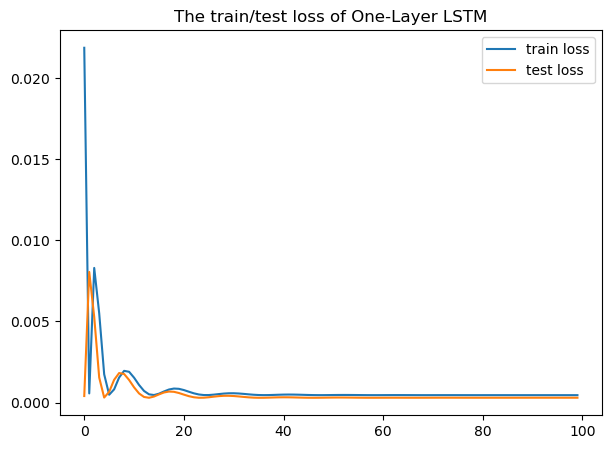

In [31]:
# Plot the train loss and calidation loss per iteration
plt.figure(figsize=(7, 5))
plt.plot(layer1_lstm_train_losses, label="train loss")
plt.plot(layer1_lstm_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of One-Layer LSTM")
plt.savefig('One-Layer LSTM loss.png')

In [32]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer1_lstm_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
    
print("---------------------------------------One-Layer LSTM----------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

---------------------------------------One-Layer LSTM----------------------------------------
Test data RMSE:  0.017223416305517665
Test data MSE:  0.00029664606923317173
Test data MAE:  0.012828175403884824


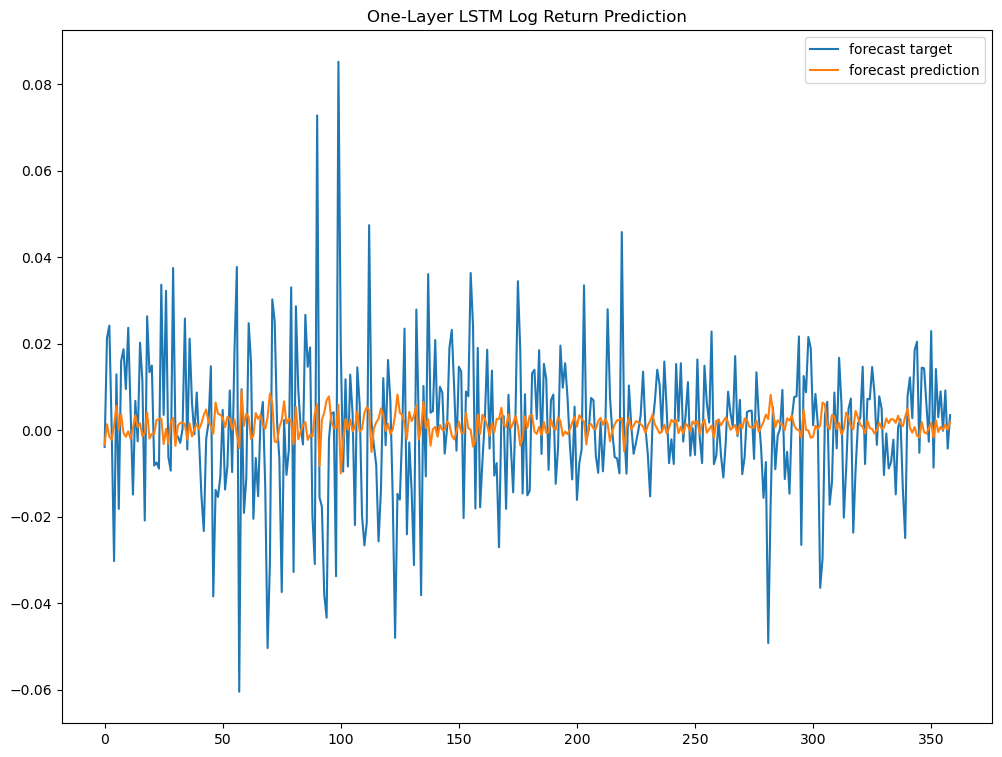

In [33]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("One-Layer LSTM Log Return Prediction")
plt.savefig('One-Layer LSTM Log Return Prediction.png')

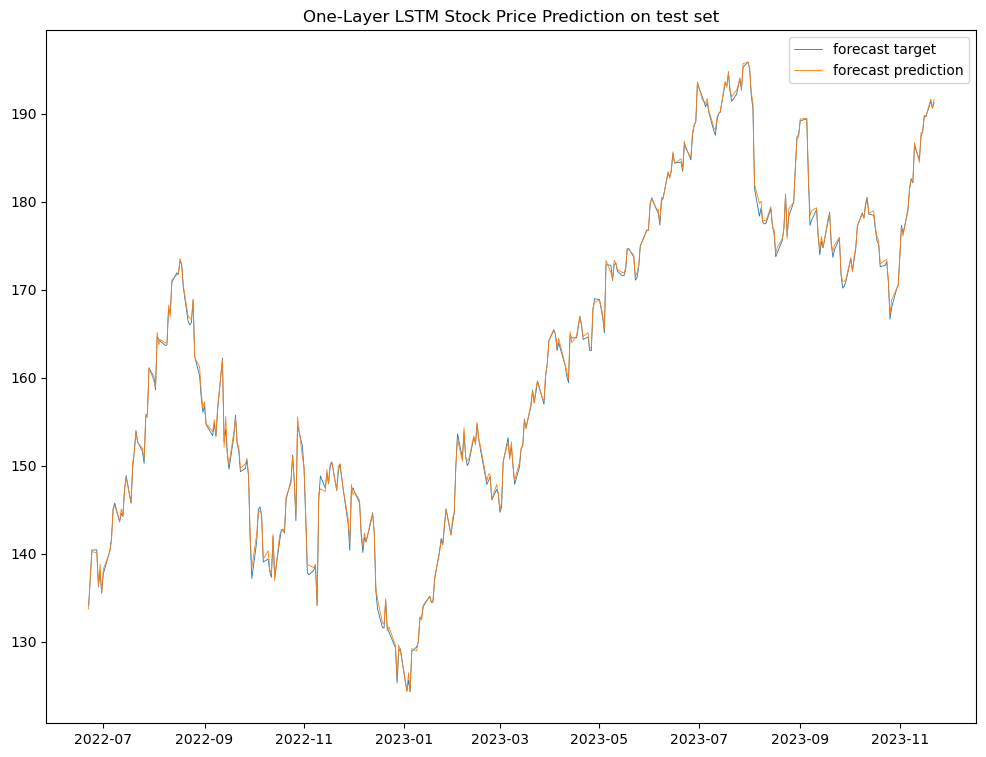

In [34]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-359:] 
plt.plot(AAPL['Adj Close'][-359:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("One-Layer LSTM Stock Price Prediction on test set")
plt.savefig('One-Layer LSTM Stock Price Prediction.png')

In [35]:
print("--------------------------------------One-Layer -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(AAPL['Adj Close'][-359:],back_pre)))
print("Test data MSE: ", mean_squared_error(AAPL['Adj Close'][-359:],back_pre))
print("Test data MAE: ", mean_absolute_error(AAPL['Adj Close'][-359:],back_pre))

--------------------------------------One-Layer -------------------------------------------
Test data RMSE:  0.4161368611110435
Test data MSE:  0.17316988717535187
Test data MAE:  0.32342383945528796


**two layer**

In [36]:
# instantiate the model
layer2_lstm_model = LSTMnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=2, n_outputs=1)
layer2_lstm_model 

LSTMnetwork(
  (rnn): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [37]:
count_parameters(layer2_lstm_model)

   200
 10000
   200
   200
 10000
 10000
   200
   200
    50
     1
______
 31051


In [38]:
layer2_lstm_criterion = nn.MSELoss()
layer2_lstm_optimizer = torch.optim.Adam(layer2_lstm_model.parameters(), lr=0.01)
layer2_lstm_train_losses, layer2_lstm_test_losses = full_gd(layer2_lstm_model,
                                            layer2_lstm_criterion,
                                            layer2_lstm_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0045, Test Loss:0.0032
Epoch 10/100, Train Loss:0.0012, Test Loss:0.0011
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 20/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


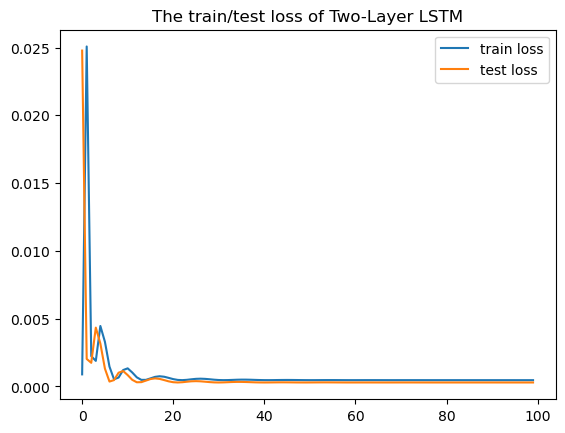

In [39]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer2_lstm_train_losses, label="train loss")
plt.plot(layer2_lstm_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Two-Layer LSTM")
plt.savefig('Two-Layer LSTM Loss.png')

In [40]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer2_lstm_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
    
print("---------------------------------------Two-Layer LSTM----------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

---------------------------------------Two-Layer LSTM----------------------------------------
Test data RMSE:  0.017078701822481297
Test data MSE:  0.0002916820559412259
Test data MAE:  0.012625643590723474


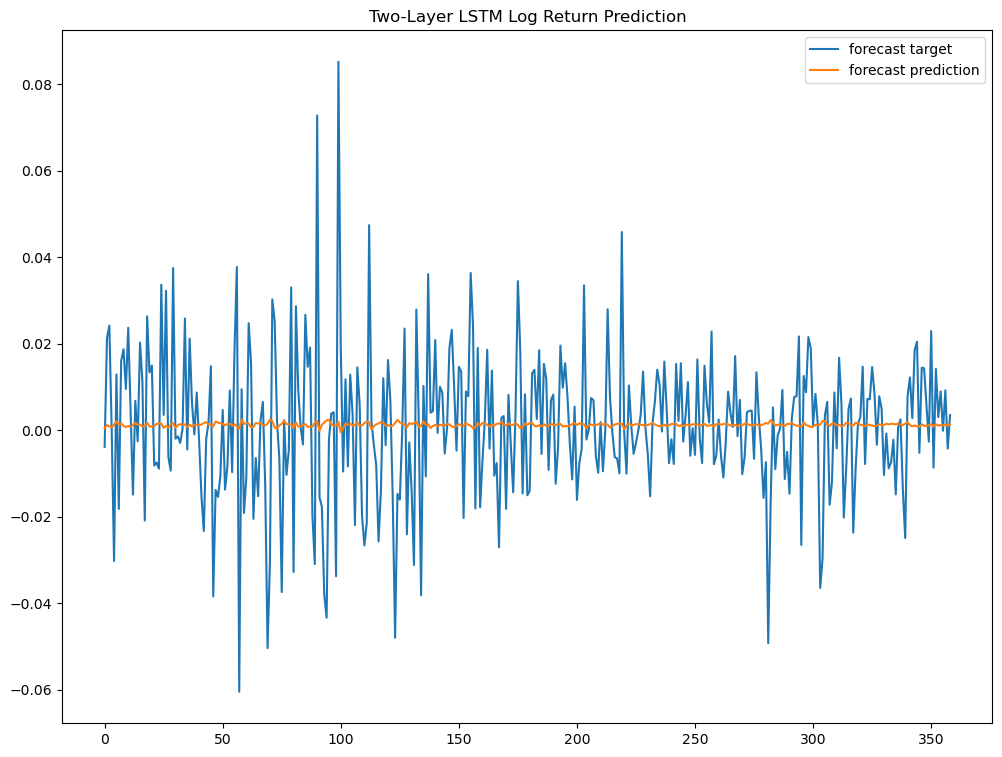

In [41]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Two-Layer LSTM Log Return Prediction")
plt.savefig('Two-Layer LSTM Log Return Prediction.png')

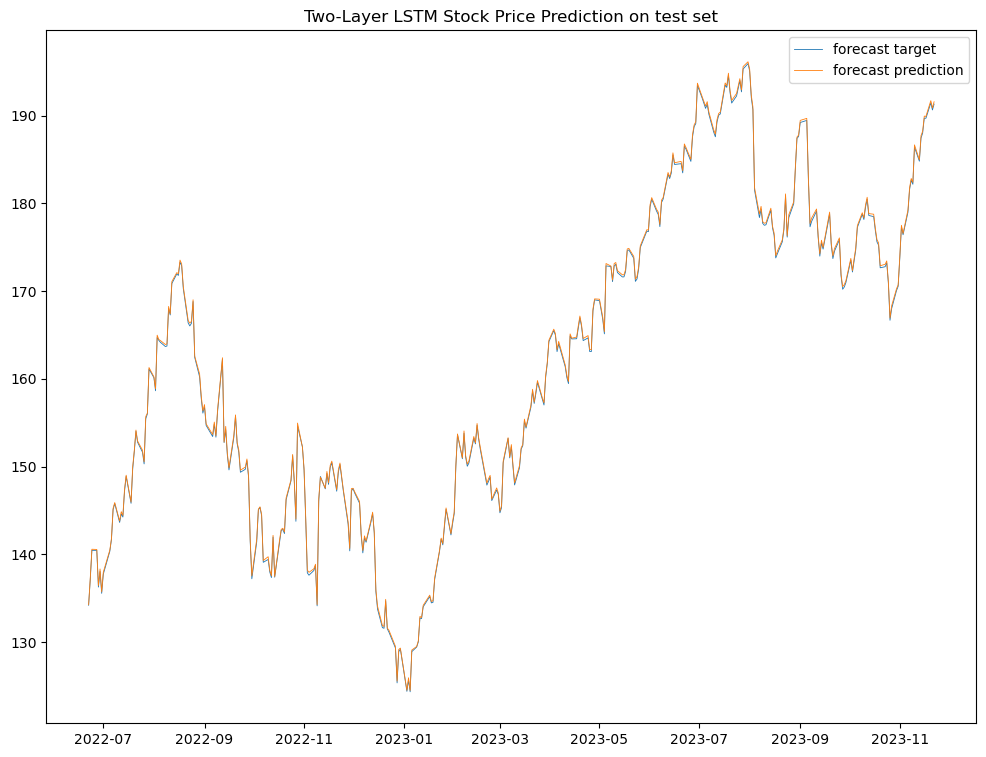

In [42]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-359:] 
plt.plot(AAPL['Adj Close'][-359:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Two-Layer LSTM Stock Price Prediction on test set")
plt.savefig('Two-Layer LSTM Stock Price Prediction.png')

In [43]:
print("--------------------------------------Two-Layer LSTM -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(AAPL['Adj Close'][-359:],back_pre)))
print("Test data MSE: ", mean_squared_error(AAPL['Adj Close'][-359:],back_pre))
print("Test data MAE: ", mean_absolute_error(AAPL['Adj Close'][-359:],back_pre))

--------------------------------------Two-Layer LSTM -------------------------------------------
Test data RMSE:  0.21610585850874878
Test data MSE:  0.046701742081803346
Test data MAE:  0.2070303578595245


## GRU

In [44]:
class GRUnetwork(nn.Module):
    
    
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(GRUnetwork, self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.GRU(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
        
        
    def forward(self,X):
        
        # initial hidden states 
        
        h0 = torch.zeros(self.L, X.size(0), self.M)
        out, _ = self.rnn(X, h0)
        
        out = self.fc(out[:,-1,:])
        return out

**one layer**

In [45]:
# instantiate the model
layer1_gru_model = GRUnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=1, n_outputs=1)
layer1_gru_model 

GRUnetwork(
  (rnn): GRU(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [46]:
layer1_gru_criterion = nn.MSELoss()
layer1_gru_optimizer = torch.optim.Adam(layer1_gru_model.parameters(), lr=0.01)

In [47]:
count_parameters(layer1_gru_model)

   150
  7500
   150
   150
    50
     1
______
  8001


In [48]:
layer1_gru_train_losses, layer1_gru_test_losses = full_gd(layer1_gru_model,
                                            layer1_gru_criterion,
                                            layer1_gru_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0011, Test Loss:0.0023
Epoch 10/100, Train Loss:0.0008, Test Loss:0.0012
Epoch 15/100, Train Loss:0.0005, Test Loss:0.0005
Epoch 20/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 25/100, Train Loss:0.0007, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 40/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


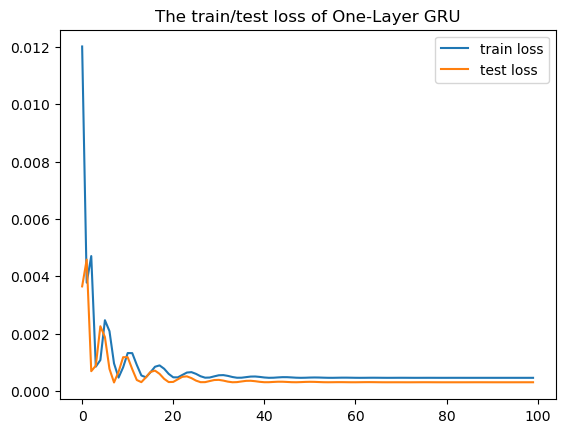

In [49]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer1_gru_train_losses, label="train loss")
plt.plot(layer1_gru_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of One-Layer GRU")
plt.savefig('One-Layer GRU Loss.png')

In [50]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer1_gru_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("----------------------------------One-Layer GRU------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

----------------------------------One-Layer GRU------------------------------------------------
Test data RMSE:  0.017299207770664245
Test data MSE:  0.00029926258949261017
Test data MAE:  0.012907689136604896


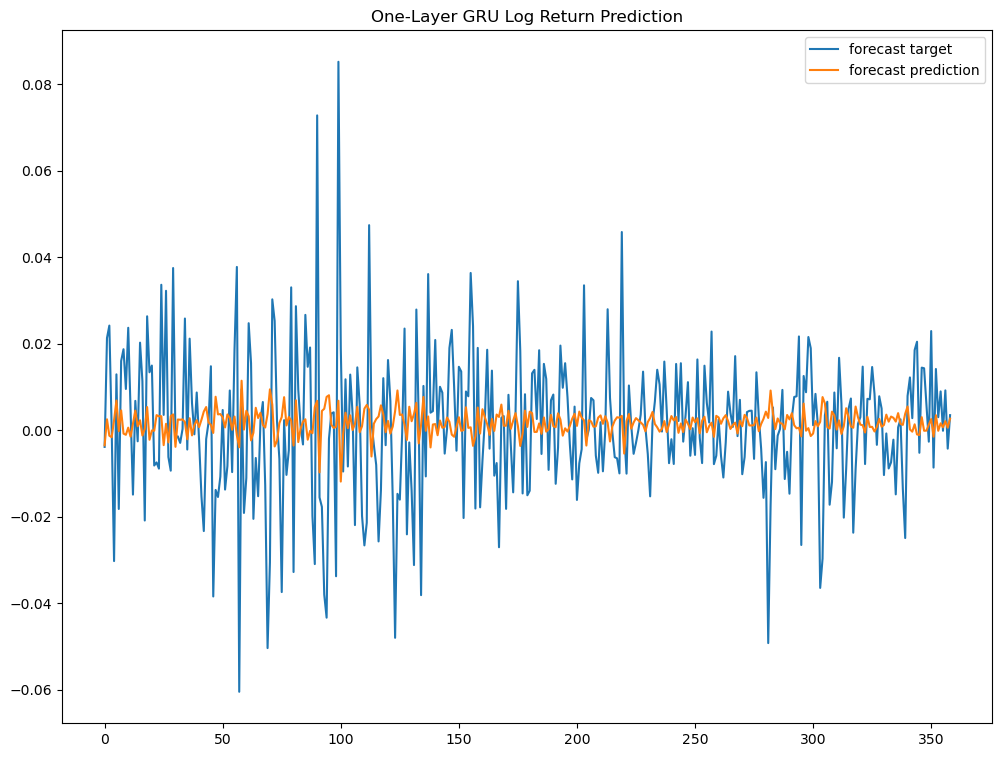

In [51]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("One-Layer GRU Log Return Prediction")
plt.savefig('One-Layer GRU Log Return Prediction.png')

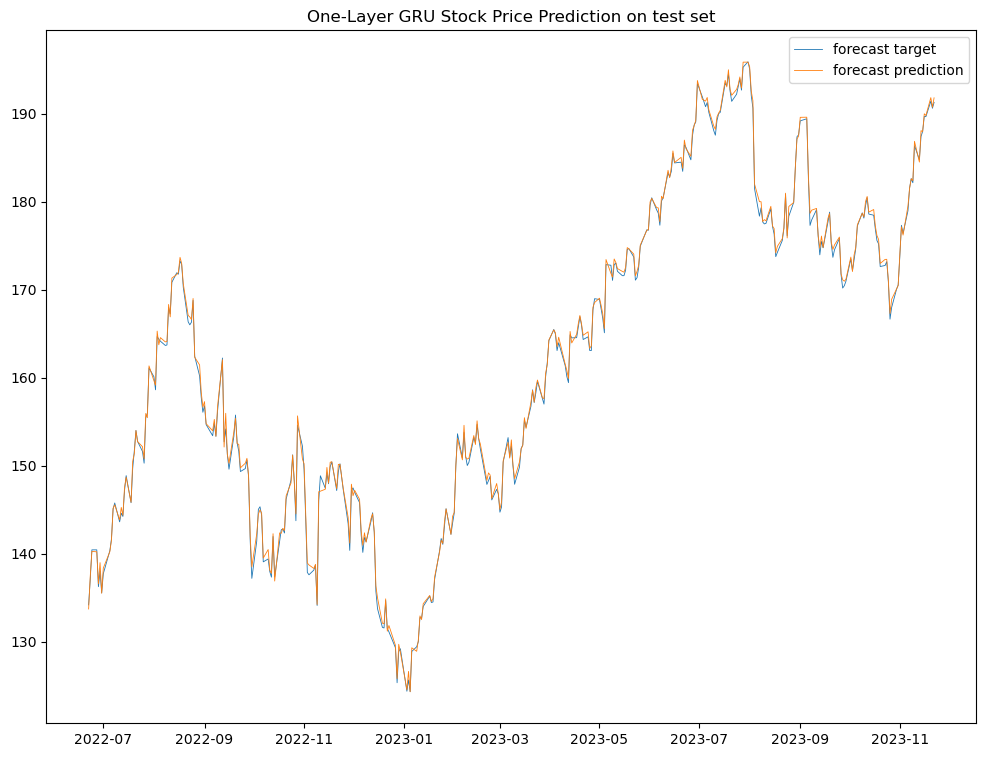

In [52]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-359:] 
plt.plot(AAPL['Adj Close'][-359:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("One-Layer GRU Stock Price Prediction on test set")
plt.savefig('One-Layer GRU Stock Price Prediction.png')

In [53]:
print("--------------------------------------One-Layer GRU -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(AAPL['Adj Close'][-359:],back_pre)))
print("Test data MSE: ", mean_squared_error(AAPL['Adj Close'][-359:],back_pre))
print("Test data MAE: ", mean_absolute_error(AAPL['Adj Close'][-359:],back_pre))

--------------------------------------One-Layer GRU -------------------------------------------
Test data RMSE:  0.4954275437836709
Test data MSE:  0.24544845113952113
Test data MAE:  0.3909345530748692


**two layer**

In [54]:
# instantiate the model
layer2_gru_model = GRUnetwork(n_inputs=1, n_hidden=50, n_rnnlayers=2, n_outputs=1)
layer2_gru_model 

GRUnetwork(
  (rnn): GRU(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [55]:
layer2_gru_criterion = nn.MSELoss()
layer2_gru_optimizer = torch.optim.Adam(layer2_gru_model.parameters(), lr=0.01)

In [56]:
count_parameters(layer2_gru_model)

   150
  7500
   150
   150
  7500
  7500
   150
   150
    50
     1
______
 23301


In [57]:
layer2_gru_train_losses, layer2_gru_test_losses = full_gd(layer2_gru_model,
                                            layer2_gru_criterion,
                                            layer2_gru_optimizer, 
                                            X_train, 
                                            y_train, 
                                            X_test, 
                                            y_test,
                                           epochs = 100)

Epoch 5/100, Train Loss:0.0177, Test Loss:0.0152
Epoch 10/100, Train Loss:0.0013, Test Loss:0.0032
Epoch 15/100, Train Loss:0.0006, Test Loss:0.0003
Epoch 20/100, Train Loss:0.0019, Test Loss:0.0015
Epoch 25/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 30/100, Train Loss:0.0009, Test Loss:0.0006
Epoch 35/100, Train Loss:0.0005, Test Loss:0.0004
Epoch 40/100, Train Loss:0.0006, Test Loss:0.0004
Epoch 45/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 50/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 55/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 60/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 65/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 70/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 75/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 80/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 85/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 90/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 95/100, Train Loss:0.0005, Test Loss:0.0003
Epoch 100/100, Train Loss:0.0005, Test Loss:0.0003


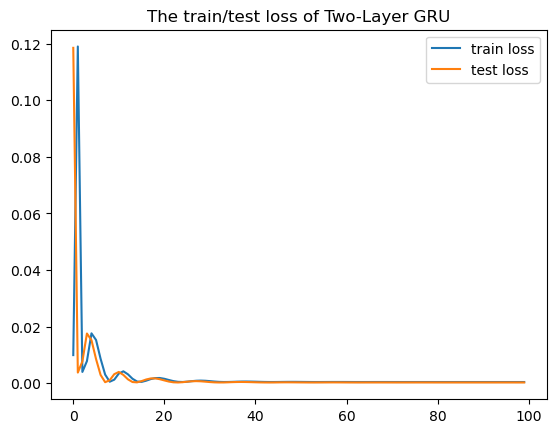

In [58]:
# Plot the train loss and calidation loss per iteration
plt.plot(layer2_gru_train_losses, label="train loss")
plt.plot(layer2_gru_test_losses, label="test loss")
plt.legend()
plt.title("The train/test loss of Two-Layer GRU")
plt.savefig('Two-Layer GRU Loss.png')

In [59]:
# one-step forecast using true targets

test_target = y_test
test_predictions = []

# index of first validation input
i = 0

while len(test_predictions) < len(test_target):
    input_ = X_test[i].reshape(1,60,1)
    p = layer2_gru_model(input_)[0,0].item()
    i += 1
    
    #update the prediction list
    test_predictions.append(p)
    
print("----------------------------------Two-Layer GRU------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(test_target,test_predictions)))
print("Test data MSE: ", mean_squared_error(test_target,test_predictions))
print("Test data MAE: ", mean_absolute_error(test_target,test_predictions))

----------------------------------Two-Layer GRU------------------------------------------------
Test data RMSE:  0.017246328906768003
Test data MSE:  0.00029743586076042157
Test data MAE:  0.012859200053751206


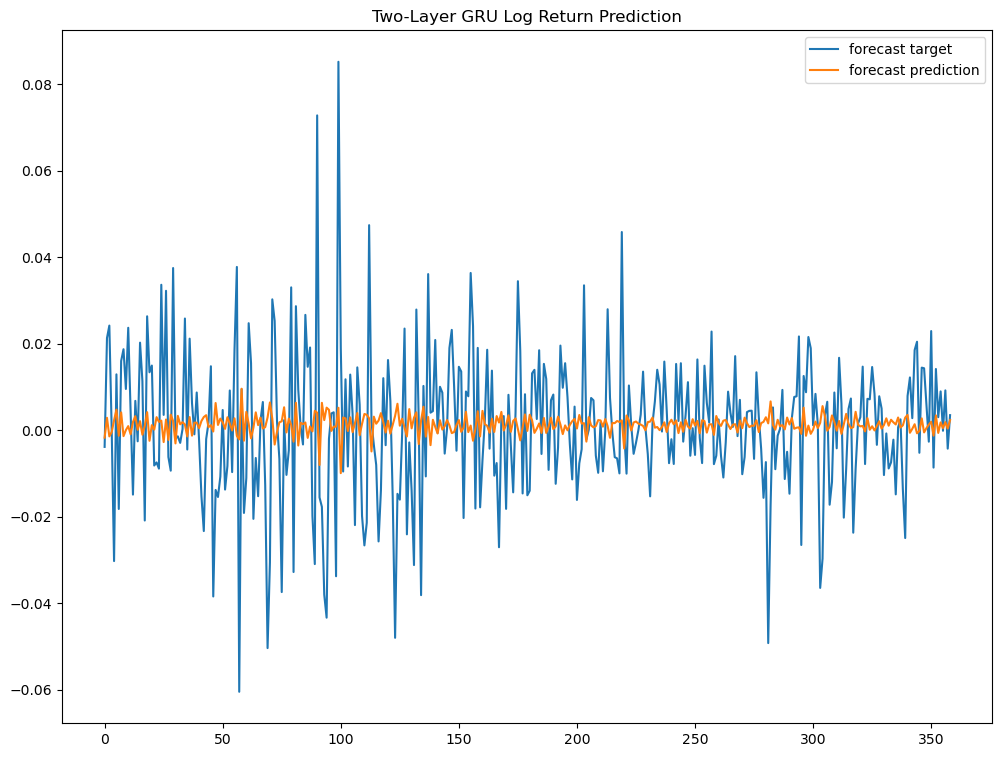

In [60]:
plt.figure(figsize=(12, 9))
plt.plot(test_target, label="forecast target")
plt.plot(test_predictions, label="forecast prediction")
plt.legend()
plt.title("Two-Layer GRU Log Return Prediction")
plt.savefig('Two-Layer GRU Log Return Prediction.png')

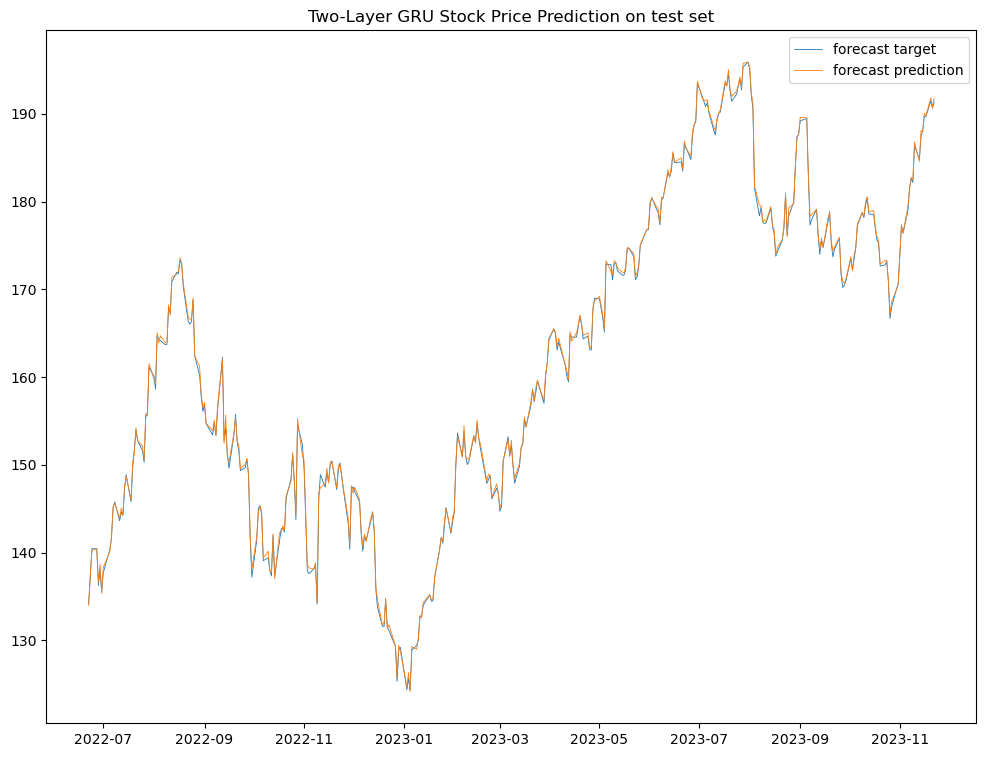

In [61]:
plt.figure(figsize=(12, 9))
vector = np.vectorize(math.exp)
back = vector(test_predictions)
back_pre = back * AAPL['Adj Close'][-359:] 
plt.plot(AAPL['Adj Close'][-359:], label="forecast target", linewidth=0.6)
plt.plot(back_pre, label="forecast prediction", linewidth=0.6)
plt.legend()
plt.title("Two-Layer GRU Stock Price Prediction on test set")
plt.savefig('Two-Layer GRU Stock Price Prediction.png')

In [72]:
print("--------------------------------------Two-Layer GRU -------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(AAPL['Adj Close'][-359:],back_pre)))
print("Test data MSE: ", mean_squared_error(AAPL['Adj Close'][-359:],back_pre))
print("Test data MAE: ", mean_absolute_error(AAPL['Adj Close'][-359:],back_pre))

--------------------------------------Two-Layer GRU -------------------------------------------
Test data RMSE:  0.38428085602490947
Test data MSE:  0.1476717763072372
Test data MAE:  0.3070135768221005


## Transformer

In [24]:
input_window = 60 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 50

close = np.array( AAPL['Adj Close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

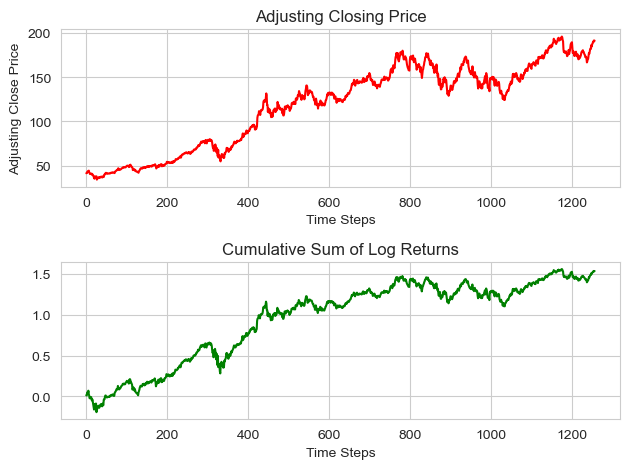

In [25]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Adjusting Closing Price')
axs[0].set_ylabel('Adjusting Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

In [26]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]       

In [27]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [28]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [29]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data
    
    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence, test_data

In [30]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

In [31]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

In [32]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)            
            total_loss += len(data[0])* criterion(output, targets).item()
    return total_loss / len(data_source)

In [33]:
def model_forecast(model, seqence):
    model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window]

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):            
            output = model(seq[-output_window:])                        
            seq = torch.cat((seq, output[-1:]))

    seq = seq.view(-1).numpy()

    return seq

In [34]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval() 
    forecast_seq = torch.Tensor(0)    
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)            
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1)), 0)
            actual = torch.cat((actual, target[-1].view(-1)), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

In [35]:
train_data, val_data = get_data(logreturn, 0.7) # 60% train, 40% test split
model = TransAm()

In [42]:
count_parameters(model)

187500
   750
 62500
   250
512000
  2048
512000
   250
   250
   250
   250
   250
187500
   750
 62500
   250
512000
  2048
512000
   250
   250
   250
   250
   250
   250
     1
______
2556847


In [36]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  250 # Number of epochs

In [37]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)
    
    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:   
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step() 

/Users/ruyuliu/anaconda3/envs/pytorchenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     3/   17 batches | lr 0.0000500000 | 48.11 ms | loss 0.4307166
| epoch   1 |     6/   17 batches | lr 0.0000500000 | 34.25 ms | loss 0.1755535
| epoch   1 |     9/   17 batches | lr 0.0000500000 | 32.24 ms | loss 0.2065578
| epoch   1 |    12/   17 batches | lr 0.0000500000 | 33.88 ms | loss 0.1622106
| epoch   1 |    15/   17 batches | lr 0.0000500000 | 32.96 ms | loss 0.0861900
--------------------------------------------------------------------------------
| end of epoch   1 | time:  0.61s
--------------------------------------------------------------------------------
| epoch   2 |     3/   17 batches | lr 0.0000451250 | 59.82 ms | loss 2.5360218
| epoch   2 |     6/   17 batches | lr 0.0000451250 | 43.65 ms | loss 0.3317869
| epoch   2 |     9/   17 batches | lr 0.0000451250 | 45.26 ms | loss 1.0993109
| epoch   2 |    12/   17 batches | lr 0.0000451250 | 45.41 ms | loss 2.3932411
| epoch   2 |    15/   17 batches | lr 0.0000451250 | 46.80 ms | loss 2.3975501
----

| epoch  15 |     3/   17 batches | lr 0.0000231646 | 60.00 ms | loss 0.0431893
| epoch  15 |     6/   17 batches | lr 0.0000231646 | 44.94 ms | loss 0.0677616
| epoch  15 |     9/   17 batches | lr 0.0000231646 | 46.39 ms | loss 0.0675895
| epoch  15 |    12/   17 batches | lr 0.0000231646 | 44.67 ms | loss 0.0309732
| epoch  15 |    15/   17 batches | lr 0.0000231646 | 45.07 ms | loss 0.1200420
--------------------------------------------------------------------------------
| end of epoch  15 | time:  0.79s
--------------------------------------------------------------------------------
| epoch  16 |     3/   17 batches | lr 0.0000220063 | 65.84 ms | loss 0.0238344
| epoch  16 |     6/   17 batches | lr 0.0000220063 | 47.29 ms | loss 0.0287978
| epoch  16 |     9/   17 batches | lr 0.0000220063 | 45.20 ms | loss 0.0277284
| epoch  16 |    12/   17 batches | lr 0.0000220063 | 45.53 ms | loss 0.0398616
| epoch  16 |    15/   17 batches | lr 0.0000220063 | 45.04 ms | loss 0.0409026
----

| epoch  29 |     3/   17 batches | lr 0.0000112968 | 65.76 ms | loss 0.0149884
| epoch  29 |     6/   17 batches | lr 0.0000112968 | 49.25 ms | loss 0.0349753
| epoch  29 |     9/   17 batches | lr 0.0000112968 | 49.56 ms | loss 0.0803278
| epoch  29 |    12/   17 batches | lr 0.0000112968 | 50.02 ms | loss 0.0563112
| epoch  29 |    15/   17 batches | lr 0.0000112968 | 47.64 ms | loss 0.0294945
--------------------------------------------------------------------------------
| end of epoch  29 | time:  0.85s
--------------------------------------------------------------------------------
| epoch  30 |     3/   17 batches | lr 0.0000107319 | 62.78 ms | loss 0.0376888
| epoch  30 |     6/   17 batches | lr 0.0000107319 | 50.19 ms | loss 0.0177088
| epoch  30 |     9/   17 batches | lr 0.0000107319 | 49.11 ms | loss 0.0275919
| epoch  30 |    12/   17 batches | lr 0.0000107319 | 48.18 ms | loss 0.0188722
| epoch  30 |    15/   17 batches | lr 0.0000107319 | 50.69 ms | loss 0.0410167
----

| epoch  43 |     3/   17 batches | lr 0.0000055092 | 68.83 ms | loss 0.0198376
| epoch  43 |     6/   17 batches | lr 0.0000055092 | 48.03 ms | loss 0.0148639
| epoch  43 |     9/   17 batches | lr 0.0000055092 | 52.82 ms | loss 0.0174236
| epoch  43 |    12/   17 batches | lr 0.0000055092 | 50.03 ms | loss 0.0159830
| epoch  43 |    15/   17 batches | lr 0.0000055092 | 48.40 ms | loss 0.0376180
--------------------------------------------------------------------------------
| end of epoch  43 | time:  0.88s
--------------------------------------------------------------------------------
| epoch  44 |     3/   17 batches | lr 0.0000052337 | 66.33 ms | loss 0.0263745
| epoch  44 |     6/   17 batches | lr 0.0000052337 | 50.67 ms | loss 0.0145138
| epoch  44 |     9/   17 batches | lr 0.0000052337 | 51.45 ms | loss 0.0221131
| epoch  44 |    12/   17 batches | lr 0.0000052337 | 48.57 ms | loss 0.0213753
| epoch  44 |    15/   17 batches | lr 0.0000052337 | 49.93 ms | loss 0.0218661
----

| epoch  57 |     3/   17 batches | lr 0.0000026867 | 67.00 ms | loss 0.0126654
| epoch  57 |     6/   17 batches | lr 0.0000026867 | 50.84 ms | loss 0.0111713
| epoch  57 |     9/   17 batches | lr 0.0000026867 | 43.70 ms | loss 0.0134232
| epoch  57 |    12/   17 batches | lr 0.0000026867 | 46.87 ms | loss 0.0120742
| epoch  57 |    15/   17 batches | lr 0.0000026867 | 50.12 ms | loss 0.0258193
--------------------------------------------------------------------------------
| end of epoch  57 | time:  0.86s
--------------------------------------------------------------------------------
| epoch  58 |     3/   17 batches | lr 0.0000025523 | 67.39 ms | loss 0.0124282
| epoch  58 |     6/   17 batches | lr 0.0000025523 | 49.65 ms | loss 0.0118638
| epoch  58 |     9/   17 batches | lr 0.0000025523 | 50.67 ms | loss 0.0145974
| epoch  58 |    12/   17 batches | lr 0.0000025523 | 47.43 ms | loss 0.0133551
| epoch  58 |    15/   17 batches | lr 0.0000025523 | 49.22 ms | loss 0.0235262
----

| epoch  71 |     6/   17 batches | lr 0.0000013102 | 53.08 ms | loss 0.0109674
| epoch  71 |     9/   17 batches | lr 0.0000013102 | 52.55 ms | loss 0.0131632
| epoch  71 |    12/   17 batches | lr 0.0000013102 | 51.10 ms | loss 0.0128145
| epoch  71 |    15/   17 batches | lr 0.0000013102 | 47.23 ms | loss 0.0198949
--------------------------------------------------------------------------------
| end of epoch  71 | time:  0.89s
--------------------------------------------------------------------------------
| epoch  72 |     3/   17 batches | lr 0.0000012447 | 68.28 ms | loss 0.0116667
| epoch  72 |     6/   17 batches | lr 0.0000012447 | 49.44 ms | loss 0.0109664
| epoch  72 |     9/   17 batches | lr 0.0000012447 | 50.41 ms | loss 0.0137369
| epoch  72 |    12/   17 batches | lr 0.0000012447 | 48.85 ms | loss 0.0124102
| epoch  72 |    15/   17 batches | lr 0.0000012447 | 49.29 ms | loss 0.0225097
--------------------------------------------------------------------------------
| e

| epoch  85 |     3/   17 batches | lr 0.0000006390 | 65.07 ms | loss 0.0116563
| epoch  85 |     6/   17 batches | lr 0.0000006390 | 48.81 ms | loss 0.0101226
| epoch  85 |     9/   17 batches | lr 0.0000006390 | 49.43 ms | loss 0.0116870
| epoch  85 |    12/   17 batches | lr 0.0000006390 | 50.67 ms | loss 0.0137852
| epoch  85 |    15/   17 batches | lr 0.0000006390 | 47.63 ms | loss 0.0208334
--------------------------------------------------------------------------------
| end of epoch  85 | time:  0.85s
--------------------------------------------------------------------------------
| epoch  86 |     3/   17 batches | lr 0.0000006070 | 66.96 ms | loss 0.0117950
| epoch  86 |     6/   17 batches | lr 0.0000006070 | 49.57 ms | loss 0.0108832
| epoch  86 |     9/   17 batches | lr 0.0000006070 | 44.47 ms | loss 0.0128274
| epoch  86 |    12/   17 batches | lr 0.0000006070 | 48.59 ms | loss 0.0120328
| epoch  86 |    15/   17 batches | lr 0.0000006070 | 50.85 ms | loss 0.0208572
----

| epoch  99 |     6/   17 batches | lr 0.0000003116 | 45.92 ms | loss 0.0102942
| epoch  99 |     9/   17 batches | lr 0.0000003116 | 44.68 ms | loss 0.0125969
| epoch  99 |    12/   17 batches | lr 0.0000003116 | 45.61 ms | loss 0.0116403
| epoch  99 |    15/   17 batches | lr 0.0000003116 | 46.39 ms | loss 0.0190282
--------------------------------------------------------------------------------
| end of epoch  99 | time:  0.80s
--------------------------------------------------------------------------------
| epoch 100 |     3/   17 batches | lr 0.0000002960 | 60.64 ms | loss 0.0112379
| epoch 100 |     6/   17 batches | lr 0.0000002960 | 49.92 ms | loss 0.0102590
| epoch 100 |     9/   17 batches | lr 0.0000002960 | 58.32 ms | loss 0.0124684
| epoch 100 |    12/   17 batches | lr 0.0000002960 | 59.95 ms | loss 0.0127078
| epoch 100 |    15/   17 batches | lr 0.0000002960 | 106.16 ms | loss 0.0204407
--------------------------------------------------------------------------------
| 

| epoch 113 |     3/   17 batches | lr 0.0000001520 | 60.75 ms | loss 0.0112931
| epoch 113 |     6/   17 batches | lr 0.0000001520 | 45.00 ms | loss 0.0104786
| epoch 113 |     9/   17 batches | lr 0.0000001520 | 44.16 ms | loss 0.0131386
| epoch 113 |    12/   17 batches | lr 0.0000001520 | 44.62 ms | loss 0.0127850
| epoch 113 |    15/   17 batches | lr 0.0000001520 | 45.83 ms | loss 0.0186907
--------------------------------------------------------------------------------
| end of epoch 113 | time:  0.79s
--------------------------------------------------------------------------------
| epoch 114 |     3/   17 batches | lr 0.0000001444 | 60.92 ms | loss 0.0116022
| epoch 114 |     6/   17 batches | lr 0.0000001444 | 44.73 ms | loss 0.0109437
| epoch 114 |     9/   17 batches | lr 0.0000001444 | 85.49 ms | loss 0.0117135
| epoch 114 |    12/   17 batches | lr 0.0000001444 | 81.10 ms | loss 0.0119897
| epoch 114 |    15/   17 batches | lr 0.0000001444 | 53.02 ms | loss 0.0194387
----

| epoch 127 |     6/   17 batches | lr 0.0000000741 | 48.96 ms | loss 0.0101794
| epoch 127 |     9/   17 batches | lr 0.0000000741 | 44.90 ms | loss 0.0122663
| epoch 127 |    12/   17 batches | lr 0.0000000741 | 45.46 ms | loss 0.0121367
| epoch 127 |    15/   17 batches | lr 0.0000000741 | 44.63 ms | loss 0.0193268
--------------------------------------------------------------------------------
| end of epoch 127 | time:  0.81s
--------------------------------------------------------------------------------
| epoch 128 |     3/   17 batches | lr 0.0000000704 | 62.23 ms | loss 0.0111436
| epoch 128 |     6/   17 batches | lr 0.0000000704 | 53.43 ms | loss 0.0103791
| epoch 128 |     9/   17 batches | lr 0.0000000704 | 47.17 ms | loss 0.0123506
| epoch 128 |    12/   17 batches | lr 0.0000000704 | 43.97 ms | loss 0.0132716
| epoch 128 |    15/   17 batches | lr 0.0000000704 | 44.70 ms | loss 0.0188538
--------------------------------------------------------------------------------
| e

| epoch 141 |     3/   17 batches | lr 0.0000000361 | 60.03 ms | loss 0.0112532
| epoch 141 |     6/   17 batches | lr 0.0000000361 | 43.88 ms | loss 0.0102890
| epoch 141 |     9/   17 batches | lr 0.0000000361 | 45.14 ms | loss 0.0117067
| epoch 141 |    12/   17 batches | lr 0.0000000361 | 44.44 ms | loss 0.0126247
| epoch 141 |    15/   17 batches | lr 0.0000000361 | 45.58 ms | loss 0.0200854
--------------------------------------------------------------------------------
| end of epoch 141 | time:  0.78s
--------------------------------------------------------------------------------
| epoch 142 |     3/   17 batches | lr 0.0000000343 | 60.00 ms | loss 0.0108322
| epoch 142 |     6/   17 batches | lr 0.0000000343 | 45.27 ms | loss 0.0102694
| epoch 142 |     9/   17 batches | lr 0.0000000343 | 44.67 ms | loss 0.0119931
| epoch 142 |    12/   17 batches | lr 0.0000000343 | 45.73 ms | loss 0.0120926
| epoch 142 |    15/   17 batches | lr 0.0000000343 | 44.94 ms | loss 0.0193681
----

| epoch 155 |     3/   17 batches | lr 0.0000000176 | 60.78 ms | loss 0.0112422
| epoch 155 |     6/   17 batches | lr 0.0000000176 | 45.76 ms | loss 0.0102206
| epoch 155 |     9/   17 batches | lr 0.0000000176 | 45.36 ms | loss 0.0126977
| epoch 155 |    12/   17 batches | lr 0.0000000176 | 45.78 ms | loss 0.0126841
| epoch 155 |    15/   17 batches | lr 0.0000000176 | 44.90 ms | loss 0.0199037
--------------------------------------------------------------------------------
| end of epoch 155 | time:  0.79s
--------------------------------------------------------------------------------
| epoch 156 |     3/   17 batches | lr 0.0000000167 | 58.72 ms | loss 0.0110881
| epoch 156 |     6/   17 batches | lr 0.0000000167 | 44.15 ms | loss 0.0099404
| epoch 156 |     9/   17 batches | lr 0.0000000167 | 44.72 ms | loss 0.0120263
| epoch 156 |    12/   17 batches | lr 0.0000000167 | 44.86 ms | loss 0.0126565
| epoch 156 |    15/   17 batches | lr 0.0000000167 | 44.55 ms | loss 0.0202078
----

| epoch 169 |     3/   17 batches | lr 0.0000000086 | 61.19 ms | loss 0.0112344
| epoch 169 |     6/   17 batches | lr 0.0000000086 | 44.42 ms | loss 0.0102260
| epoch 169 |     9/   17 batches | lr 0.0000000086 | 45.70 ms | loss 0.0122005
| epoch 169 |    12/   17 batches | lr 0.0000000086 | 44.53 ms | loss 0.0124524
| epoch 169 |    15/   17 batches | lr 0.0000000086 | 44.34 ms | loss 0.0198588
--------------------------------------------------------------------------------
| end of epoch 169 | time:  0.79s
--------------------------------------------------------------------------------
| epoch 170 |     3/   17 batches | lr 0.0000000082 | 60.55 ms | loss 0.0112532
| epoch 170 |     6/   17 batches | lr 0.0000000082 | 44.16 ms | loss 0.0109513
| epoch 170 |     9/   17 batches | lr 0.0000000082 | 44.55 ms | loss 0.0120763
| epoch 170 |    12/   17 batches | lr 0.0000000082 | 45.24 ms | loss 0.0121991
| epoch 170 |    15/   17 batches | lr 0.0000000082 | 45.55 ms | loss 0.0189091
----

| epoch 183 |     3/   17 batches | lr 0.0000000042 | 87.39 ms | loss 0.0112187
| epoch 183 |     6/   17 batches | lr 0.0000000042 | 49.41 ms | loss 0.0108136
| epoch 183 |     9/   17 batches | lr 0.0000000042 | 46.61 ms | loss 0.0126186
| epoch 183 |    12/   17 batches | lr 0.0000000042 | 45.99 ms | loss 0.0125501
| epoch 183 |    15/   17 batches | lr 0.0000000042 | 51.83 ms | loss 0.0196184
--------------------------------------------------------------------------------
| end of epoch 183 | time:  0.93s
--------------------------------------------------------------------------------
| epoch 184 |     3/   17 batches | lr 0.0000000040 | 65.00 ms | loss 0.0114036
| epoch 184 |     6/   17 batches | lr 0.0000000040 | 45.05 ms | loss 0.0106450
| epoch 184 |     9/   17 batches | lr 0.0000000040 | 45.49 ms | loss 0.0120036
| epoch 184 |    12/   17 batches | lr 0.0000000040 | 45.11 ms | loss 0.0121736
| epoch 184 |    15/   17 batches | lr 0.0000000040 | 45.42 ms | loss 0.0189931
----

| epoch 197 |     3/   17 batches | lr 0.0000000020 | 61.47 ms | loss 0.0104490
| epoch 197 |     6/   17 batches | lr 0.0000000020 | 46.59 ms | loss 0.0106466
| epoch 197 |     9/   17 batches | lr 0.0000000020 | 45.10 ms | loss 0.0120803
| epoch 197 |    12/   17 batches | lr 0.0000000020 | 45.88 ms | loss 0.0122062
| epoch 197 |    15/   17 batches | lr 0.0000000020 | 47.31 ms | loss 0.0199295
--------------------------------------------------------------------------------
| end of epoch 197 | time:  0.81s
--------------------------------------------------------------------------------
| epoch 198 |     3/   17 batches | lr 0.0000000019 | 61.18 ms | loss 0.0120111
| epoch 198 |     6/   17 batches | lr 0.0000000019 | 46.86 ms | loss 0.0104698
| epoch 198 |     9/   17 batches | lr 0.0000000019 | 47.63 ms | loss 0.0118112
| epoch 198 |    12/   17 batches | lr 0.0000000019 | 45.46 ms | loss 0.0124838
| epoch 198 |    15/   17 batches | lr 0.0000000019 | 47.60 ms | loss 0.0189826
----

| epoch 211 |     3/   17 batches | lr 0.0000000010 | 72.64 ms | loss 0.0109180
| epoch 211 |     6/   17 batches | lr 0.0000000010 | 56.77 ms | loss 0.0110956
| epoch 211 |     9/   17 batches | lr 0.0000000010 | 51.54 ms | loss 0.0121721
| epoch 211 |    12/   17 batches | lr 0.0000000010 | 55.07 ms | loss 0.0126870
| epoch 211 |    15/   17 batches | lr 0.0000000010 | 52.53 ms | loss 0.0199711
--------------------------------------------------------------------------------
| end of epoch 211 | time:  0.95s
--------------------------------------------------------------------------------
| epoch 212 |     3/   17 batches | lr 0.0000000009 | 66.97 ms | loss 0.0108640
| epoch 212 |     6/   17 batches | lr 0.0000000009 | 52.33 ms | loss 0.0103611
| epoch 212 |     9/   17 batches | lr 0.0000000009 | 54.31 ms | loss 0.0130260
| epoch 212 |    12/   17 batches | lr 0.0000000009 | 58.00 ms | loss 0.0122160
| epoch 212 |    15/   17 batches | lr 0.0000000009 | 49.47 ms | loss 0.0189797
----

| epoch 225 |     3/   17 batches | lr 0.0000000005 | 62.10 ms | loss 0.0119145
| epoch 225 |     6/   17 batches | lr 0.0000000005 | 45.38 ms | loss 0.0105757
| epoch 225 |     9/   17 batches | lr 0.0000000005 | 45.18 ms | loss 0.0117615
| epoch 225 |    12/   17 batches | lr 0.0000000005 | 45.50 ms | loss 0.0127959
| epoch 225 |    15/   17 batches | lr 0.0000000005 | 45.53 ms | loss 0.0195155
--------------------------------------------------------------------------------
| end of epoch 225 | time:  0.80s
--------------------------------------------------------------------------------
| epoch 226 |     3/   17 batches | lr 0.0000000005 | 60.64 ms | loss 0.0111428
| epoch 226 |     6/   17 batches | lr 0.0000000005 | 44.65 ms | loss 0.0104499
| epoch 226 |     9/   17 batches | lr 0.0000000005 | 45.97 ms | loss 0.0120996
| epoch 226 |    12/   17 batches | lr 0.0000000005 | 44.64 ms | loss 0.0117996
| epoch 226 |    15/   17 batches | lr 0.0000000005 | 44.72 ms | loss 0.0203161
----

| epoch 239 |     3/   17 batches | lr 0.0000000002 | 59.60 ms | loss 0.0108751
| epoch 239 |     6/   17 batches | lr 0.0000000002 | 45.27 ms | loss 0.0105027
| epoch 239 |     9/   17 batches | lr 0.0000000002 | 46.97 ms | loss 0.0123080
| epoch 239 |    12/   17 batches | lr 0.0000000002 | 46.17 ms | loss 0.0124350
| epoch 239 |    15/   17 batches | lr 0.0000000002 | 46.35 ms | loss 0.0205224
--------------------------------------------------------------------------------
| end of epoch 239 | time:  0.80s
--------------------------------------------------------------------------------
| epoch 240 |     3/   17 batches | lr 0.0000000002 | 61.69 ms | loss 0.0114392
| epoch 240 |     6/   17 batches | lr 0.0000000002 | 44.90 ms | loss 0.0100192
| epoch 240 |     9/   17 batches | lr 0.0000000002 | 45.93 ms | loss 0.0123056
| epoch 240 |    12/   17 batches | lr 0.0000000002 | 45.02 ms | loss 0.0118927
| epoch 240 |    15/   17 batches | lr 0.0000000002 | 45.32 ms | loss 0.0197417
----

In [38]:
test_result, truth = forecast_seq(model, val_data)

0.5762739181518555 sec


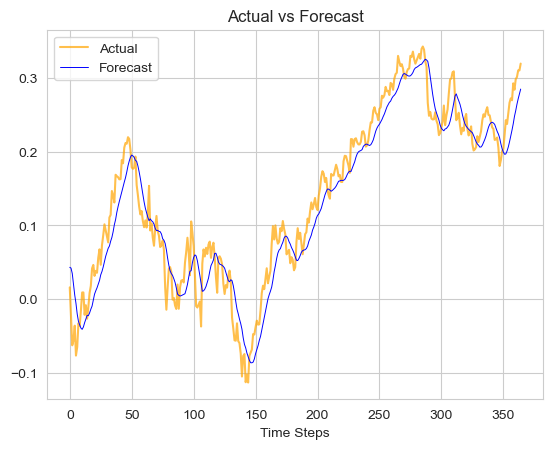

In [39]:
plt.plot(truth, color='orange', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

In [20]:
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(truth,test_result)))
print("Test data MSE: ", mean_squared_error(truth,test_result))
print("Test data MAE: ", mean_absolute_error(truth,test_result))

-------------------------------------------------------------------------------------
Test data RMSE:  0.10740987537293342
Test data MSE:  0.011536881
Test data MAE:  0.09368201
